In [121]:
%load_ext autoreload
%autoreload 2

import os
import pickle

from config import Config

import matplotlib.pyplot as plt
import numpy as np
from utility import format_decomp_name, format_dataset_name

plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "Times New Roman"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [122]:
RESULTS_FOLDER = "results/experiment_9/"
c = Config()
algorithm_names = c.algorithm_names_generic_intra
dataset_names = ["illness"]

In [123]:
all_times = np.full((len(algorithm_names),len(c.dataset_names),len(c.decomp_intra_names), 2), -1.0)

for i, algorithm in enumerate(algorithm_names):
    folder = RESULTS_FOLDER + algorithm + "/"
    for j, dataset in enumerate(dataset_names):
        if not os.path.exists(folder + dataset + ".pkl"):
            continue
        with open(folder + dataset + ".pkl", "rb") as file:
            errors = pickle.load(file)
            for k, decomp in enumerate(c.decomp_intra_names):
                all_times[i,j,k,0] = errors[decomp]["mean_time"]
                all_times[i,j,k,1] = errors[decomp]["std_time"]
# only one algo and dataset
all_times = all_times[0,0,:,:]
mean_times = all_times[:,0]
std_times = all_times[:,1]

In [124]:
n_components = [1,2,2,3,6]
component_duration = np.mean([mean_times[1]-mean_times[0],mean_times[2]-mean_times[0]])

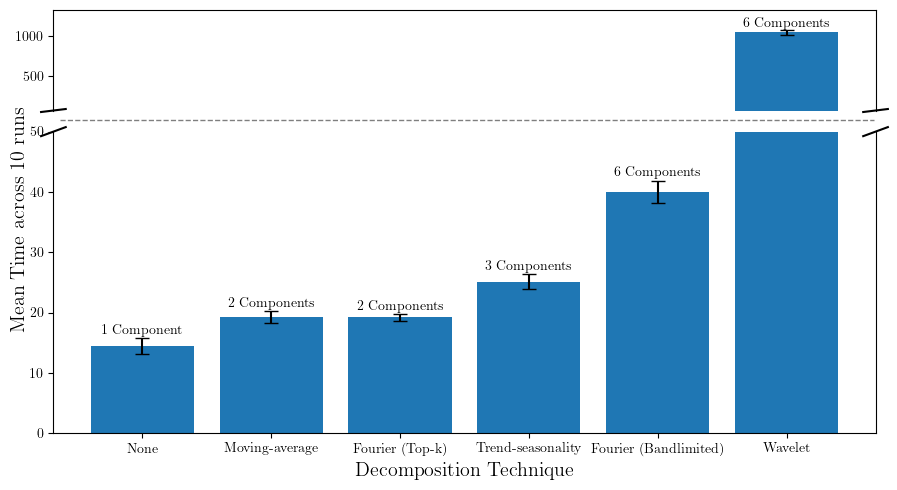

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

decomp_names = np.array([format_decomp_name(decomp) for decomp in c.decomp_intra_names])

outlier_threshold = 50
non_outlier_indices = [i for i, val in enumerate(mean_times) if val <= outlier_threshold]
outlier_indices = [i for i, val in enumerate(mean_times) if val > outlier_threshold]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9,5), sharex=True, gridspec_kw={"height_ratios": [1, 3]})

sort_order = np.argsort(mean_times)
mean_times_sorted = mean_times[sort_order]
std_times_sorted = std_times[sort_order]
decomp_names = decomp_names[sort_order]

# Top subplot: For the outlier
bars_top = ax1.bar(decomp_names, mean_times_sorted, yerr=std_times_sorted, capsize=5)
ax1.set_ylim(outlier_threshold+25, max(mean_times_sorted) + max(std_times_sorted)*10)
ax1.spines["bottom"].set_visible(False)
ax1.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)


# Bottom subplot: For the smaller values
bars = ax2.bar(decomp_names, mean_times_sorted, yerr=std_times_sorted, capsize=5)
ax2.set_ylim(0, outlier_threshold)
ax2.spines['top'].set_visible(False)

for bar, n_comp, std in zip(bars, n_components, std_times_sorted):
    height = bar.get_height()

    ax2.text(
        bar.get_x() + bar.get_width() / 2,
        height+std*1.2,
        f"{n_comp} Components" if n_comp != 1 else f"1 Component",
        ha="center", va="bottom",
        fontsize=10
    )


ax1.text(
    bars_top[-1].get_x() + bars_top[-1].get_width() / 2,
    bars_top[-1].get_height()+std_times_sorted[-1]*1.2,
    f"6 Components",
    ha="center", va="bottom",
    fontsize=10
)

# Add diagonal lines to show the break in the y-axis
d = 0.015
kwargs = dict(transform=ax1.transAxes, color="black", clip_on=False)
ax1.plot((-d, +d), (-d, +d), **kwargs)
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)
kwargs = dict(transform=ax2.transAxes, color="black", clip_on=False)
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)

# Add labels and title
ax2.set_xlabel("Decomposition Technique", fontsize="x-large")
fig.text(s="Mean Time (s) across 10 trials",x=0.01, y=0.55, fontdict={"fontsize": "x-large"}, rotation=90, va="center")
line = Line2D(
    xdata=[0.065, 0.97],  # From left to right of the figure
    ydata=[0.75, 0.75],  # 0.7 is in figure-relative coordinates
    transform=fig.transFigure,  # Use figure-relative coordinates
    color=("black", 0.5),
    linestyle="--",
    linewidth=1
)
fig.add_artist(line)
plt.tight_layout()
fig.savefig("plots/runtime.pdf", bbox_inches="tight")